# What's cooking? - Data Science class project 

This project is about __predicting__ the type of cuisine from a list of ingredients. In this notebook, we, as a team, process and analyze the dataset to train a machine learning model to make predictions

Participants:
- Daniel Felipe Barrera Suarez - 20212020097
- Andres Julian Vargas Medina - 20221020069
- Santiago Reyes Gomez - 20221020098


In [394]:
# General
import pandas as pd
import numpy as np
import re
from typing import List

# Web Scrapping
import requests
from bs4 import BeautifulSoup
import sys

# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# Cleaning
import nltk
from nltk.stem import WordNetLemmatizer
import unidecode

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [395]:
# !python.exe -m pip install --upgrade pip
# !pip install pandas
# !pip install numpy
# !pip install unidecode
# !pip install bs4
# !pip install requests
# !pip install nltk
# !pip install BeautifulSoup4
# !pip install scikit-learn
# !pip install xgboost
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install regex

# # Download wordnet and omw to lemmatize words
# nltk.download('wordnet')
# nltk.download('omw-1.4')

## Data Collection

### Web Scrapping

In [396]:
urls = ['https://www.calories.info/food/potato-products', 'https://www.calories.info/food/vegetables-legumes', 'https://www.calories.info/food/mushrooms', 'https://www.calories.info/food/salad', 'https://www.calories.info/food/fruit', 'https://www.calories.info/food/milk-dairy-products', 'https://www.calories.info/food/yogurt', 'https://www.calories.info/food/cheese', 'https://www.calories.info/food/cream-cheese', 'https://www.calories.info/food/meat', 'https://www.calories.info/food/beef-veal', 'https://www.calories.info/food/pork', 'https://www.calories.info/food/poultry-chicken-turkey', 'https://www.calories.info/food/ham-sausage', 'https://www.calories.info/food/rice-products', 'https://www.calories.info/food/bread-rolls-pastries', 'https://www.calories.info/food/pasta-noodles', 'https://www.calories.info/food/flour-grains-baking-ingredients', 'https://www.calories.info/food/cereal', 'https://www.calories.info/food/fish-seafood', 'https://www.calories.info/food/meals-dishes', 'https://www.calories.info/food/fast-food-burgers', 'https://www.calories.info/food/pizza', 'https://www.calories.info/food/sushi', 'https://www.calories.info/food/juice-soft-drinks', 'https://www.calories.info/food/coffee', 'https://www.calories.info/food/wine', 'https://www.calories.info/food/beer', 'https://www.calories.info/food/liquor-cocktails', 'https://www.calories.info/food/sweets-chocolate-cookies-candy', 'https://www.calories.info/food/ice-cream', 'https://www.calories.info/food/cakes-pies', 'https://www.calories.info/food/desserts-pudding', 'https://www.calories.info/food/nuts-seeds', 'https://www.calories.info/food/oils-fats', 'https://www.calories.info/food/tofu-vegan-products', 'https://www.calories.info/food/supplements-protein-powder', 'https://www.calories.info/food/sauces-gravy-dressing-spreads', 'https://www.calories.info/food/herbs-spices-tea', 'https://www.calories.info/food/chips-popcorn-snacks']

# Check if the data has already been scrapped, because it takes a long time
try: 
    scrapping_df = pd.read_csv('scrapping.csv')
except:
    scrapping_df = pd.DataFrame(columns=['ingredient', 'calories'])

    for url in urls:
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
        else:
            print("ERROR. Failed to retrieve data using web scrapping.")
            sys.exit(1)

        # Extract the table content
        td_list = soup.find_all('td', class_='css-1xc9rzw')
        ingredients = [td.get_text() for td in td_list]

        td_list = soup.find_all('td', class_='css-1ll19ui')
        calories = [td.get_text() for td in td_list]

        td_list = soup.find_all('td', class_='css-yu17rd')
        calories_100g = [td.get_text() for td in td_list]

        td_list = soup.find_all('p', class_='css-1yv7hsn')
        grams = [td.get_text() for td in td_list if td.get_text() != '100 g' and td.get_text() != '100 ml']
        grams.pop()
        grams = [re.findall(r'\d+', str)[-1] for str in grams]

        # if grams > 150, change calories to calories_100g
        for i, gram in enumerate(grams):
            if int(gram) > 150:
                calories[i] = calories_100g[i]

        scrapping_df2 = pd.DataFrame({'ingredient': ingredients, 'calories': calories})
        scrapping_df = pd.concat([scrapping_df, scrapping_df2])

    scrapping_df = scrapping_df[scrapping_df['ingredient'] != '']
    scrapping_df = scrapping_df[scrapping_df['calories'] != 'NaN cal']
    scrapping_df['ingredient'] = scrapping_df['ingredient'].apply(lambda x: re.sub(r',', '', x))
    scrapping_df['calories'] = scrapping_df['calories'].apply(lambda x: re.match(r'\d+', x).group())
    scrapping_df['ingredient'] = scrapping_df['ingredient'].apply(lambda x: x.lower())
    scrapping_df['calories'] = scrapping_df['calories'].astype(int)

    scrapping_df.to_csv('scrapping.csv', index=False)
    
scrapping_df.head()

,ingredient,calories
0,baked potato,122
1,baked potato with sour cream,130
2,boiled potato,88
3,croquettes,63
4,curly fries (mccain),425


### Data from kaggle

In [397]:
train_df = pd.read_json('assets/train.json')

### Understanding data (EDA)


In [398]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [399]:
print('shape:', train_df.shape)
print('id column is unique?:', train_df['id'].is_unique)

train_df.head()

shape: (39774, 3)
id column is unique?: True


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [400]:
# Add EDA estatistics

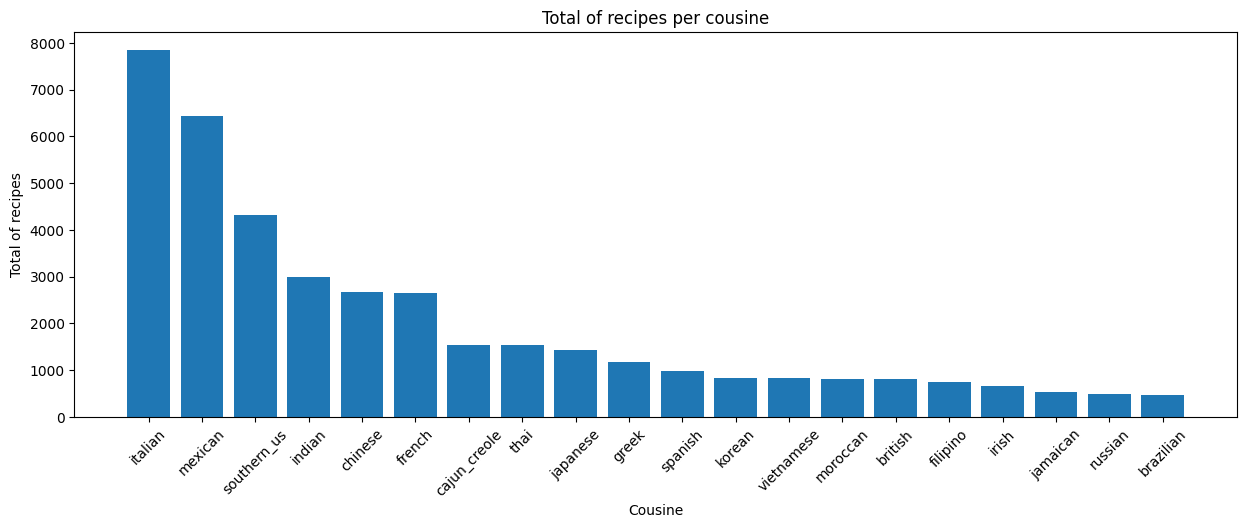

In [401]:
fig = plt.figure(figsize=(15, 5))

cousine_categories = train_df['cuisine'].value_counts()

plt.bar(cousine_categories.index, cousine_categories.values)
plt.title('Total of recipes per cousine')
plt.ylabel('Total of recipes')
plt.xlabel('Cousine')
plt.xticks(rotation=45)
plt.show()

### Missing values


In [402]:
train_df.isna().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

## Data Preprocessing

### Data Cleaning


In [403]:
def cleaning(list: List) -> list:
    """
    This function cleans the list of ingredients by removing numbers, measurement units, special characters, accents, and lemmat

    Args:
        list: list of ingredients
    
    Returns:
        list: list of cleaned ingredients
    """
    for i in range(len(list)):
        list[i] = list[i].lower()

        if list[i] != '7 up': list[i] = re.sub(r'\d+', '', list[i]) # Removing numbers
        list[i] = re.sub(r'\s*\(.*oz\.\)\s*', '', list[i])
        list[i] = re.sub(r'-', ' ', list[i])
        list[i] = re.sub(r"[^\w\s]", '', list[i]) # Removing no words (special characters)

        list[i] = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b\s'), '', list[i]) # Removing measurement units

        for word in list[i].split():
            if len(word) <= 2 and list[i] != '7 up': # Removing words with len <= 2, except for '7 up'
                list[i] = re.sub(fr"\b{word}\b", '', list[i])
            
            unicoded_word = unidecode.unidecode(word) # Removing accents
            if unicoded_word != word:
                list[i] = list[i].replace(word, unicoded_word) 

            lemmatized_word = WordNetLemmatizer().lemmatize(word) #Lemmatize words
            if lemmatized_word != word:
                list[i] = list[i].replace(word, lemmatized_word)
                

        list[i] = re.sub(r"\s\s+", ' ', list[i]) # Removing double or more blank spaces or more
        list[i] = list[i].strip() # Removing blank spaces at start or end

    return list

cleaned_train_df = train_df.copy()
cleaned_train_df['ingredients'] = cleaned_train_df['ingredients'].apply(cleaning)

### Data Preparation

In [404]:
train_df = cleaned_train_df.copy()

# converting list of ingredients to a string
train_df['ingredients'] = train_df['ingredients'].apply(lambda x: ' '.join(x))

## Feature Engineering

### Creating a new column with the quantity of ingredients

In [405]:
train_df['ingredients quantity'] = cleaned_train_df['ingredients'].apply(len)

### Adding calories feature from scrapping after cleaning train data

In [406]:
ingredients_set = set(scrapping_df['ingredient'])

def stimated_calories_sum(list: List) -> int:
    """
    This function calculates the sum of calories of the ingredients in the list taking into account the scrapping data

    Args:
        list: list of ingredients

    Returns:
        int: sum of calories
    """	

    sum = 0
    for ingredient in list:
        if ingredient in ingredients_set:
            sum += scrapping_df.loc[scrapping_df['ingredient'] == ingredient, 'calories'].iloc[0] 
    return sum

train_df['estimated calories'] = cleaned_train_df['ingredients'].apply(stimated_calories_sum)

In [407]:
train_df.head()

,id,cuisine,ingredients,ingredients quantity,estimated calories
0,10259,greek,romaine lettuce black olive grape tomato garli...,9,44
1,25693,southern_us,plain flour ground pepper salt tomato ground b...,11,125
2,20130,filipino,egg pepper salt mayonaise cooking oil green ch...,12,281
3,22213,indian,water vegetable oil wheat salt,4,0
4,13162,indian,black pepper shallot cornflour cayenne pepper ...,20,601


## Model Selection

### Split into test dataset and train dataset

In [408]:
df_to_train = train_df.copy()

vectorizer = CountVectorizer()

le = LabelEncoder()
df_to_train['cuisine'] = le.fit_transform(df_to_train['cuisine'])

X = vectorizer.fit_transform(df_to_train['ingredients']) 
Y = df_to_train['cuisine']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### LogisticRegression

In [409]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, Y_train)

y_hat_lr = model.predict(X_test)

accuracy = accuracy_score(Y_test, y_hat_lr)
print("Accuracy:", accuracy)

Accuracy: 0.7824520237995475


### KNeighborsClassifier

In [410]:
model = KNeighborsClassifier()

model.fit(X_train, Y_train)

y_hat_knn = model.predict(X_test)

accuracy = accuracy_score(Y_test, y_hat_knn)
print("Accuracy:", accuracy)

Accuracy: 0.6412469622056483


### RandomForestClassifier

In [411]:
model = RandomForestClassifier()

model.fit(X_train, Y_train)

y_hat_rfc = model.predict(X_test)

accuracy = accuracy_score(Y_test, y_hat_rfc)
print("Accuracy:", accuracy)

Accuracy: 0.7549652224922484


### XGBClassifier

In [412]:
model = xgb.XGBClassifier()

model.fit(X_train, Y_train)

y_hat_xgb = model.predict(X_test)

accuracy = accuracy_score(Y_test, y_hat_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.791921562054806


### Models Comparasion

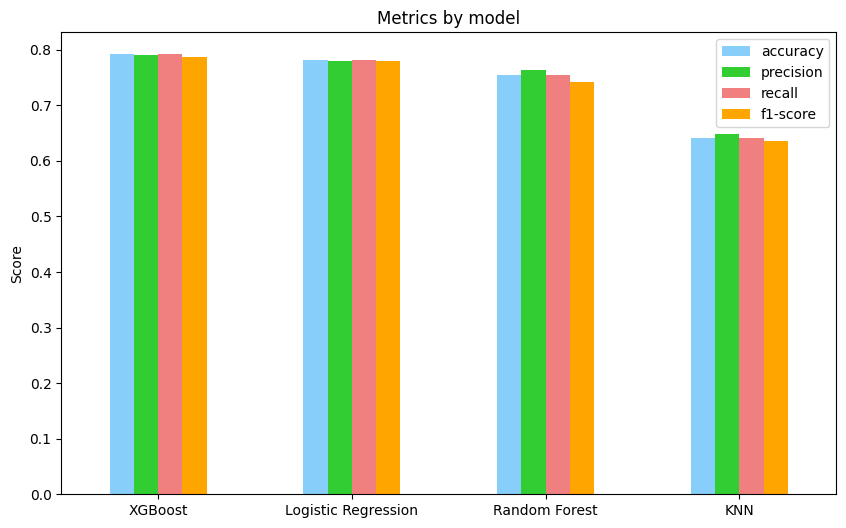

In [413]:
metrics = {
    'accuracy': [accuracy_score(Y_test, y_hat_xgb), 
                 accuracy_score(Y_test, y_hat_lr), 
                 accuracy_score(Y_test, y_hat_rfc), 
                 accuracy_score(Y_test, y_hat_knn)],
    'precision': [precision_score(Y_test, y_hat_xgb, average='weighted'), 
                  precision_score(Y_test, y_hat_lr, average='weighted'), 
                  precision_score(Y_test, y_hat_rfc, average='weighted'), 
                  precision_score(Y_test, y_hat_knn, average='weighted')],
    'recall': [recall_score(Y_test, y_hat_xgb, average='weighted'), 
               recall_score(Y_test, y_hat_lr, average='weighted'), 
               recall_score(Y_test, y_hat_rfc, average='weighted'), 
               recall_score(Y_test, y_hat_knn, average='weighted')],
    'f1-score': [f1_score(Y_test, y_hat_xgb, average='weighted'), 
                 f1_score(Y_test, y_hat_lr, average='weighted'), 
                 f1_score(Y_test, y_hat_rfc, average='weighted'), 
                 f1_score(Y_test, y_hat_knn, average='weighted')]
}

# Crear un data frame para las métricas
metrics_df = pd.DataFrame(metrics, index=['XGBoost', 'Logistic Regression', 'Random Forest', 'KNN'])

# Plotear las métricas
metrics_df.plot(kind='bar', figsize=(10, 6), color=['lightskyblue', 'limegreen', 'lightcoral', 'orange'])
plt.title('Metrics by model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

## Model Training

The most accurate model is the XGBoost model

In [414]:
# Prepraing data for the model
df_to_train = train_df.copy()

# Feature selection
X = df_to_train[['ingredients', 'estimated calories', 'ingredients quantity']] 
Y = df_to_train['cuisine']

# Scaling the data - Label encoder
le = LabelEncoder()
Y = le.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Transforming the data with count vectorizer and standard scaler
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'ingredients'),
        ('num', 'passthrough', ['estimated calories', 'ingredients quantity'])
    ])

# setting the model with the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])

# training the model
model.fit(X_train, Y_train)

# predicting the model
y_hat_xgb = model.predict(X_test)

accuracy = accuracy_score(Y_test, y_hat_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.7901617363613509


## Model Evaluation

### Bar plot with the metrics

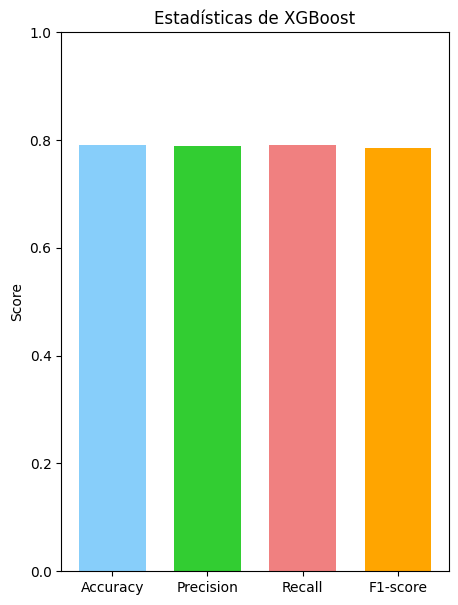

In [415]:
# converting the metrics to a data frame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Score': [accuracy_score(Y_test, y_hat_xgb), 
              precision_score(Y_test, y_hat_xgb, average='weighted'), 
              recall_score(Y_test, y_hat_xgb, average='weighted'), 
              f1_score(Y_test, y_hat_xgb, average='weighted')]
})

# Plotting the metrics
plt.figure(figsize=(5, 7))
plt.bar(metrics_df['Metric'], metrics_df['Score'], width=0.7, color=['lightskyblue', 'limegreen', 'lightcoral', 'orange'])
plt.ylim(0, 1)
plt.title('Estadísticas de XGBoost')
plt.ylabel('Score')
plt.show()

### Heat map of the confusion matrix

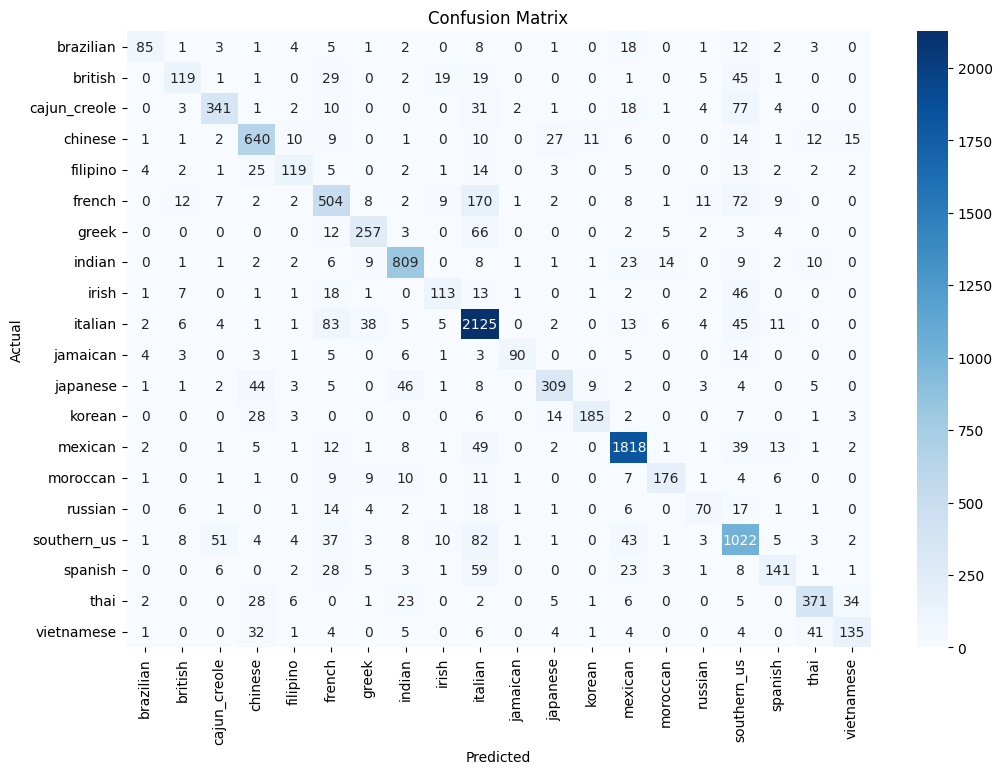

In [416]:
# Get the confusion matrix
cm = confusion_matrix(Y_test, y_hat_xgb)

# Get the original class labels from the label encoder
class_labels = le.inverse_transform(sorted(set(Y_test)))

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()


### Box plot about real vs predicted

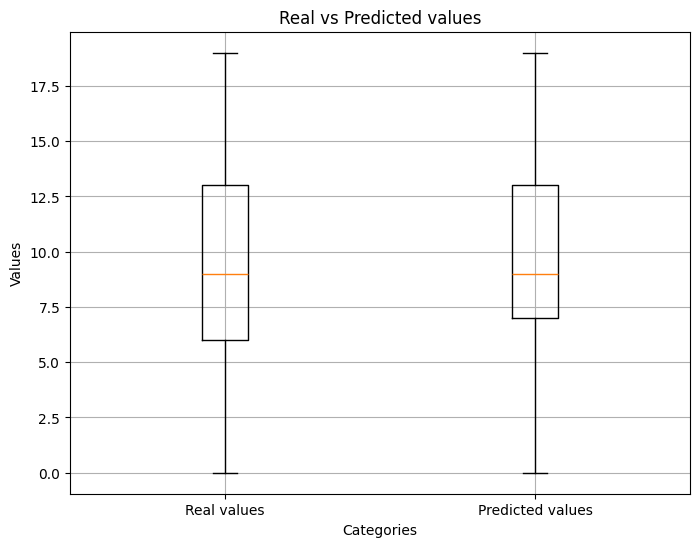

In [417]:
# Create a dictionary with the real and predicted values
data = {
    'Real values': Y_test,
    'Predicted values': y_hat_xgb
}

# Plot the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data.values(), tick_labels=data.keys())
plt.title('Real vs Predicted values')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.grid(True)
plt.show()

## Business Questions


1. What are the top 10 most common ingredients in all recipes?

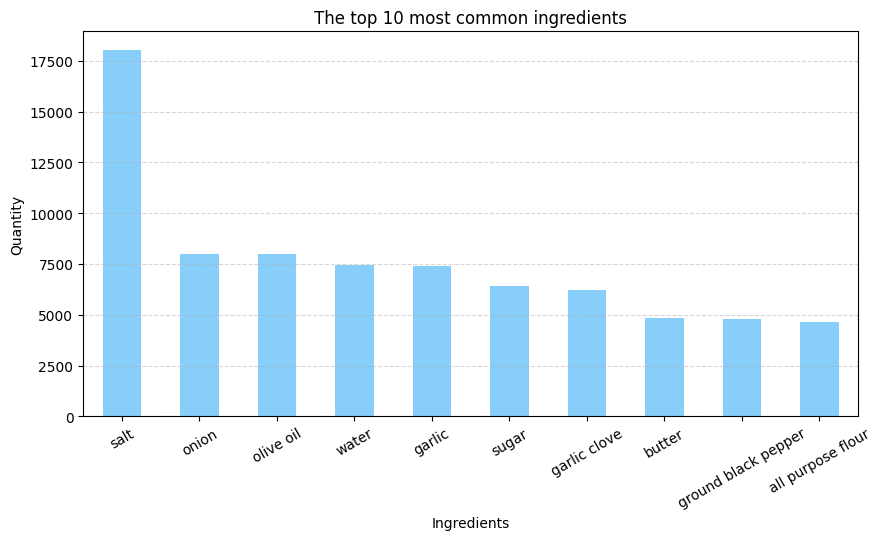

In [418]:
most_common_ingredients2 = cleaned_train_df['ingredients'].explode().value_counts().head(10)

plt.figure(figsize=(10, 5))
most_common_ingredients2.plot(kind='bar', color='lightskyblue')
plt.title('The top 10 most common ingredients')
plt.xlabel('Ingredients')
plt.ylabel('Quantity')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=30)
plt.show()

2. What are the top 5 cuisines with the highest mean stimated calories?

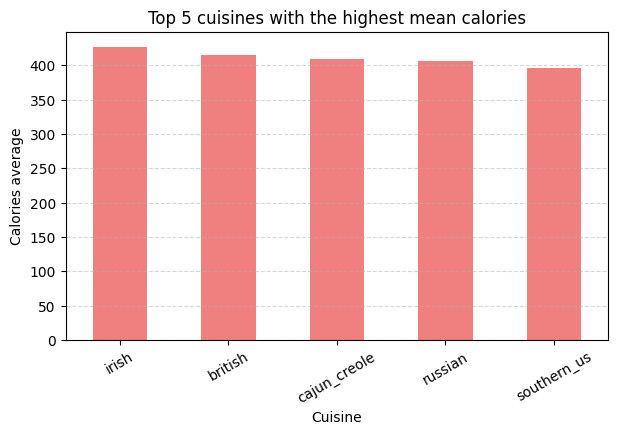

In [419]:
mean_calories =  train_df.groupby('cuisine')['estimated calories'].mean().sort_values(ascending=False).head(5)

plt.figure(figsize=(7, 4))
mean_calories.plot(kind='bar', color='lightcoral')
plt.title('Top 5 cuisines with the highest mean calories')
plt.xlabel('Cuisine')
plt.ylabel('Calories average')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=30)
plt.show()

3. What is the correlation between the number of ingredients and the estimated calories?

In [420]:
correlation = train_df['ingredients quantity'].corr(train_df['estimated calories'])
print('The correlation is:', correlation)

The correlation is: 0.3940017462986144


4. What is the relation between the number of ingredients and the cuisine?

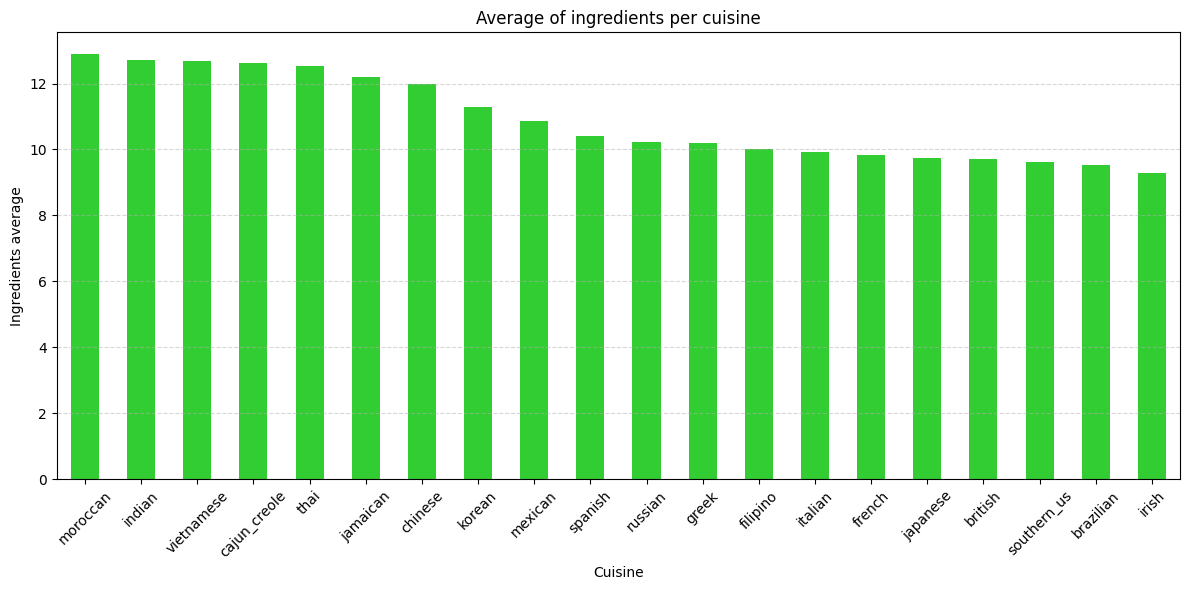

In [421]:
cleaned_train_df['ingredients quantity'] = train_df['ingredients quantity']

avg_ingredients_per_cuisine = train_df.groupby('cuisine')['ingredients quantity'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_ingredients_per_cuisine.plot(kind='bar', color='limegreen')
plt.title('Average of ingredients per cuisine')
plt.xlabel('Cuisine')
plt.ylabel('Ingredients average')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5. which ingredients are most common in each cuisine

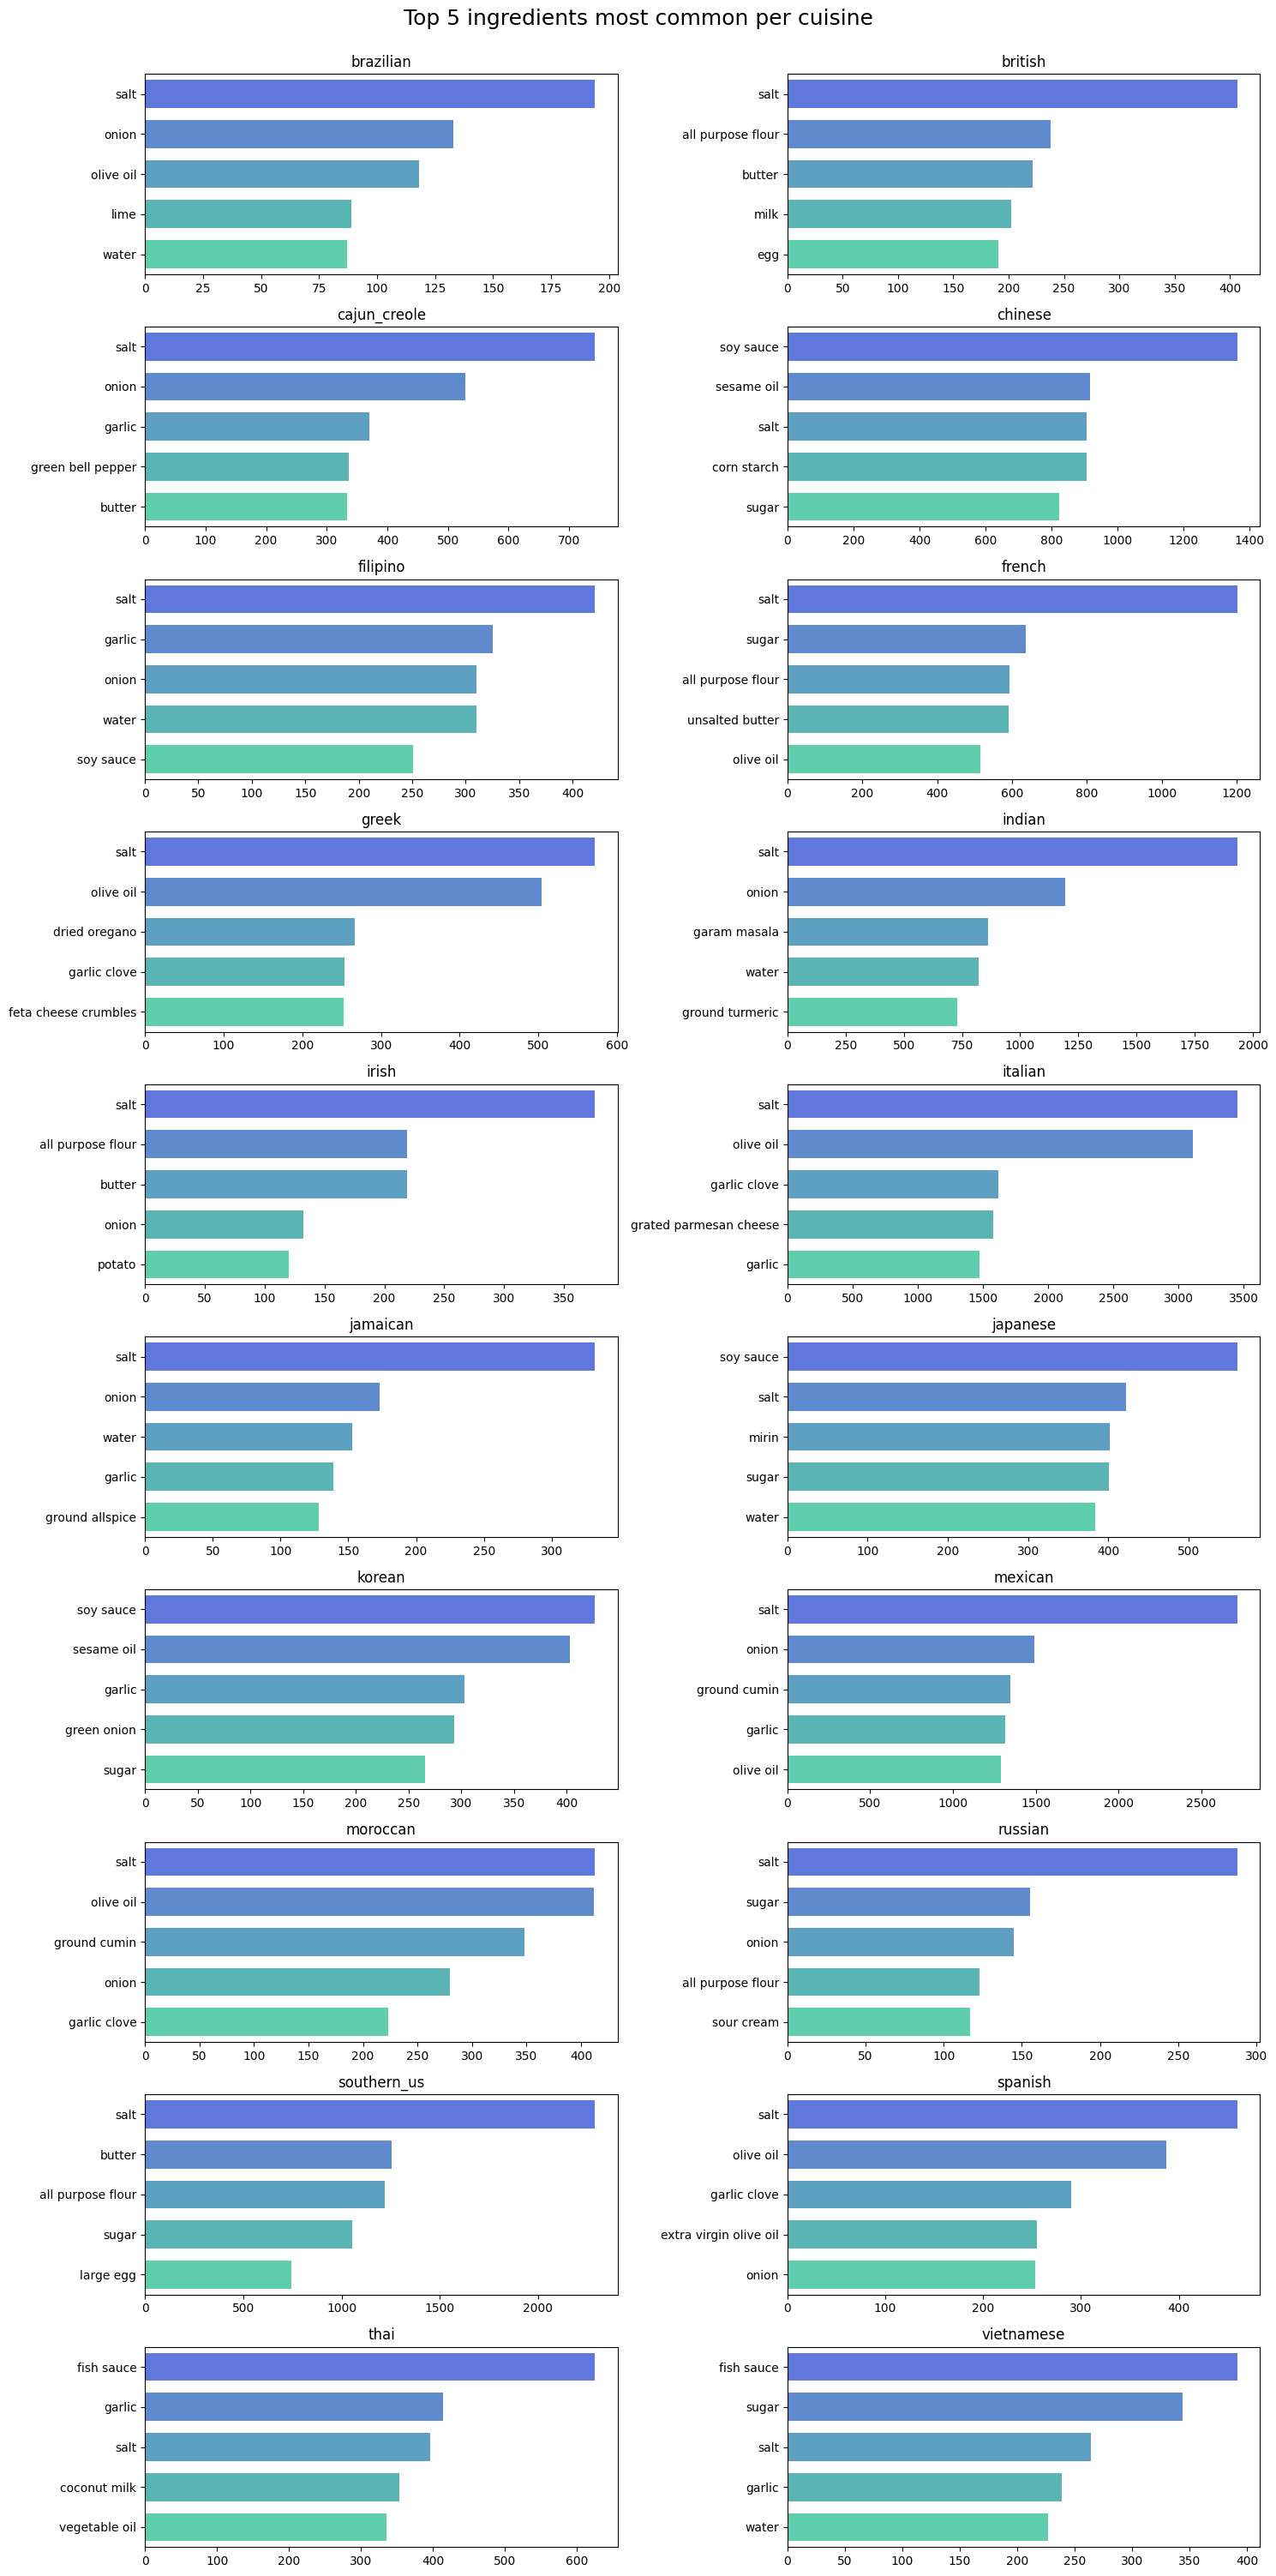

In [422]:
# divide the list of ingredients into separate rows
ingredients_expanded = cleaned_train_df.explode('ingredients')

# count the number of times each ingredient appears in each cuisine
ingredient_counts = ingredients_expanded.groupby(['cuisine', 'ingredients']).size().reset_index(name='count')

# get the top 5 ingredients per cuisine
top_ingredients_per_cuisine = ingredient_counts.sort_values(['cuisine', 'count'], ascending=[True, False]).groupby('cuisine').head(5).reset_index(drop=True)

# unique cuisines
cuisines = top_ingredients_per_cuisine['cuisine'].unique()

# set up the subplots
num_cuisines = len(cuisines)
fig, axes = plt.subplots(nrows=(num_cuisines + 1) // 2, ncols=2, figsize=(15, num_cuisines * 1.5))
fig.suptitle('Top 5 ingredients most common per cuisine', fontsize=18, y=1) 

# plain axes to iterate over
axes = axes.flatten()

# create a bar plot for each cuisine
for i, cuisine in enumerate(cuisines):
    subset = top_ingredients_per_cuisine[top_ingredients_per_cuisine['cuisine'] == cuisine]
    sns.barplot(x='count', y='ingredients', data=subset, ax=axes[i], width=0.7, palette='winter', hue='ingredients', alpha=0.7)
    axes[i].set_title(cuisine)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# set up the layout
plt.tight_layout()
plt.show()